In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm


# from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
# from replay.experimental.scenarios.movielens_wrapper.MIPS import MIPS
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

# import obp
# from obp.dataset import OpenBanditDataset
# from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [4]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/15 10:41:20 WARN Utils: Your hostname, sudakovcom-MS-7D48 resolves to a loopback address: 127.0.1.1; using 10.255.173.26 instead (on interface enp3s0)
24/09/15 10:41:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/15 10:41:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/15 10:41:24 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [5]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
dataset = MovielensBanditDataset(data)

15-Sep-24 10:41:30, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


15-Sep-24 10:41:37, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
15-Sep-24 10:41:38, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model
predict started


100%|██████████| 100000/100000 [00:08<00:00, 12348.41it/s]


In [7]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

100%|██████████| 30000/30000 [00:02<00:00, 12211.87it/s]


70000
30000


In [8]:
bandit_feedback_train.keys()

dict_keys(['log', 'item_features', 'user_features', 'n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

The keys of the dictionary are as follows.
- n_rounds: number of rounds, data size of the logged bandit data;
- n_actions: number of actions $|\mathcal{A}|$;
- action: action variables sampled by the behavior policy;
- position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface;
- reward: binary reward variables, click indicators;
- pscore: action choice probabilities by the behavior policy, propensity scores;
- context: context vectors such as user-related features and user-item affinity scores;
- action_context: item-related context vectors

In [9]:
#Define replay model
model_1 = UCB(exploration_coef = 2.0, sample = True, seed = 123)
model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
model_3 = RandomRec(seed=42)

#Define learner which connects OBP data format with replay
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1) #len_list is the number of predicted items per user
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2) #len_list is the number of predicted items per user
learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3)

**RePlayOfflinePolicyLearner** has the following methods
- *fit(action, reward, timestamp, context, action_context)*;
- *predict(n_rounds, context)* (context can be None thus n_rounds is **required**);
- *optimize(bandit_feedback, val_size, param_borders, criterion, budget, new_study)*

In [10]:
#Fit replay model inside our learner
learner_1.fit(bandit_feedback_train)
learner_2.fit(bandit_feedback_train)
learner_3.fit(bandit_feedback_train)

In [11]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(dataset.n_actions,
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

In [12]:
estimated_rewards_by_reg_model.shape

(30000, 3883, 1)

When we get distribution over actions - we can run any evaluation procedure from the OBP. Here we use three estimators
- *IPW*: Average rewards with importance weights
- *DM*: Average predicted rewards using the classifier
- *DR*: Combination of the above methods with zero bias and lower variance

Also, we can construct confidence intervals for each of these methods.

In [13]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], dataset.n_actions, 1))
    if isinstance(learner.replay_model, (LinUCB)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 10
        num_batchs = log_distinct.shape[0] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            log_subset = log_distinct.iloc[i*batch_size: j]
            n_rounds = log_subset.shape[0]
            
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[i*batch_size:j] = action_dist
    return all_action_dist

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
#Predict distribution over actions: shape (n_rounds, n_actions)
import time
start = time.time()
learner_action_dist_1 = get_dist(learner_1)
print(time.time() - start)

start = time.time()
learner_action_dist_2 = get_dist(learner_2)
print(time.time() - start)

start = time.time()
learner_action_dist_3 = get_dist(learner_3)
print(time.time() - start)

 99%|█████████▉| 100/101 [00:17<00:00,  5.80it/s]


17.280911922454834


100%|██████████| 28/28 [00:06<00:00,  4.05it/s]


6.9661688804626465


 99%|█████████▉| 100/101 [00:14<00:00,  6.82it/s]

14.682082891464233


In [16]:
def run_exp(learner_action_dist):
    Vs = []
    CIs = []

    for n_size in [5000, 10000, 15000, 20000, 25000, 30000]:
    # for n_size in [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :]
        
        action_dist = learner_action_dist[:n_size, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=10000,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [17]:
Vs_1, CIs_1 = run_exp(learner_action_dist_1)

n_size = 5000 time:  2.889420747756958
n_size = 10000 time:  5.322780132293701
n_size = 15000 time:  4.012796878814697
n_size = 20000 time:  10.24955439567566
n_size = 25000 time:  8.876380205154419
n_size = 30000 time:  7.642375946044922


In [18]:
Vs_2, CIs_2 = run_exp(learner_action_dist_2)

n_size = 5000 time:  2.8713254928588867
n_size = 10000 time:  5.32991886138916
n_size = 15000 time:  4.011470079421997
n_size = 20000 time:  10.27231478691101
n_size = 25000 time:  8.896616220474243
n_size = 30000 time:  7.63934850692749


In [19]:
Vs_3, CIs_3 = run_exp(learner_action_dist_3)

n_size = 5000 time:  2.866755247116089
n_size = 10000 time:  5.312640190124512
n_size = 15000 time:  4.015744924545288
n_size = 20000 time:  10.258385181427002
n_size = 25000 time:  8.874171495437622
n_size = 30000 time:  7.6250834465026855


In [20]:
import matplotlib.pyplot as plt
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(4, figsize=(10, 10))

    x = [5000, 10000, 15000, 20000, 25000, 30000]
    # x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

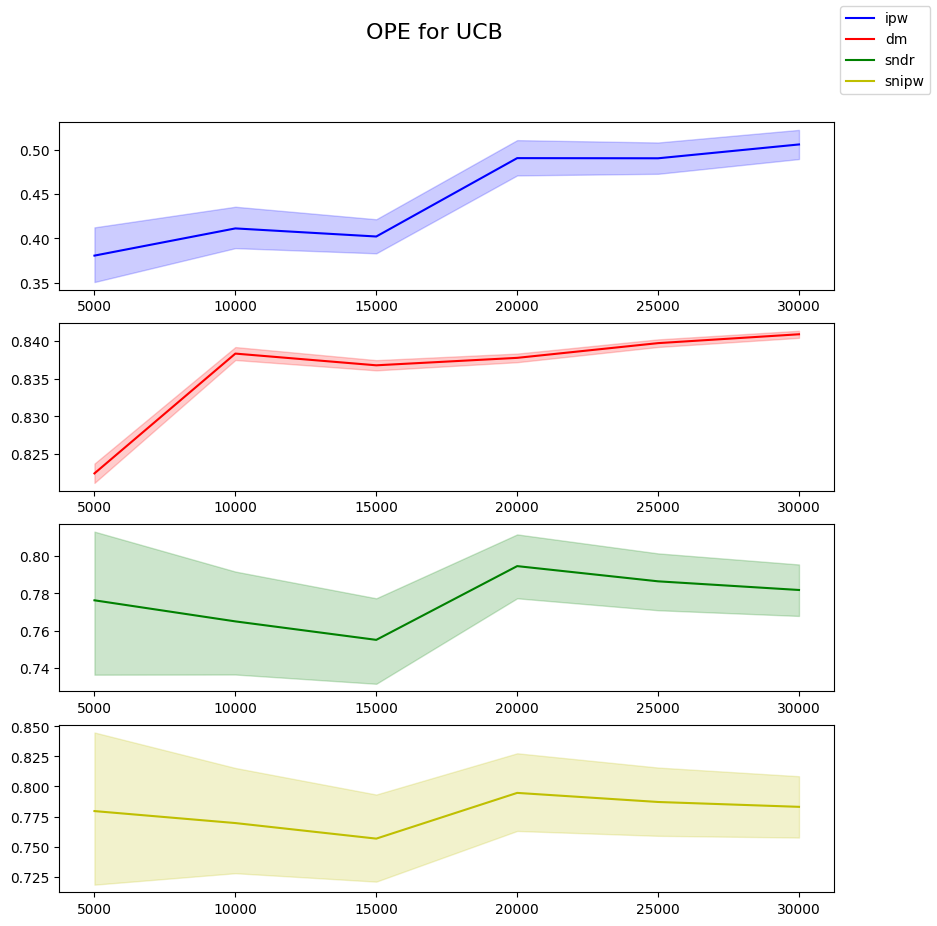

In [21]:
plot_disjoint_res(Vs_1, CIs_1, 'UCB')

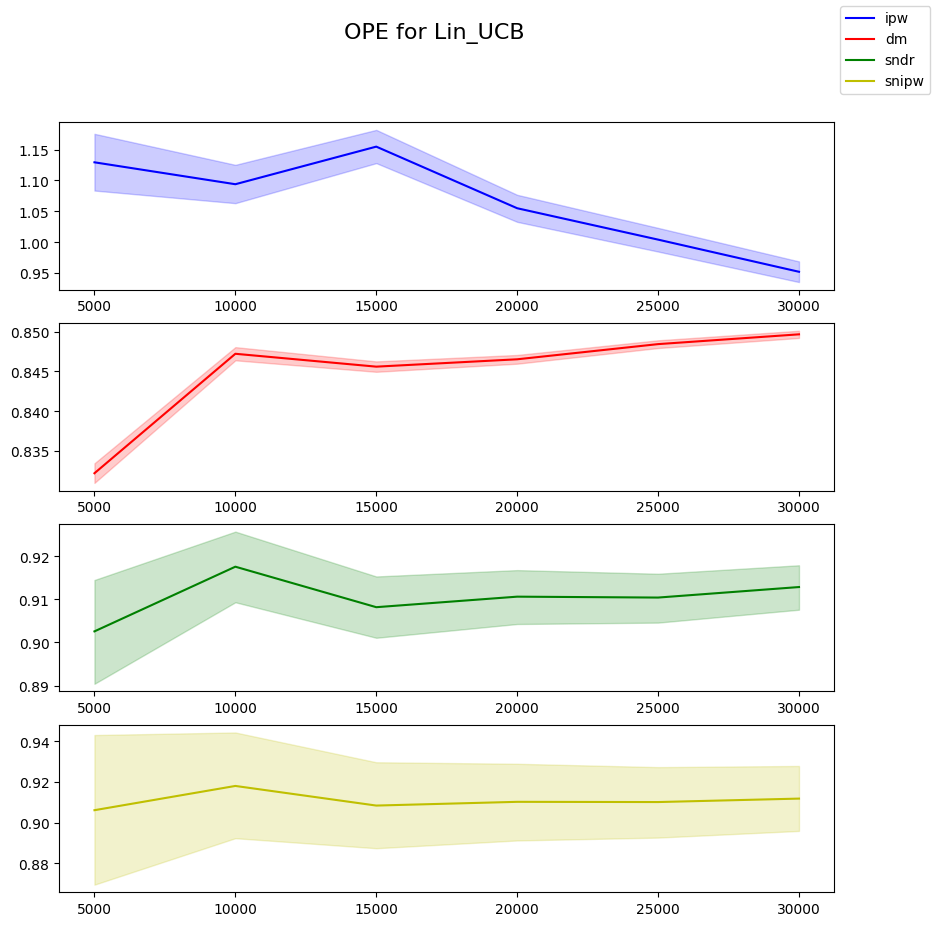

In [22]:
plot_disjoint_res(Vs_2, CIs_2, 'Lin_UCB')

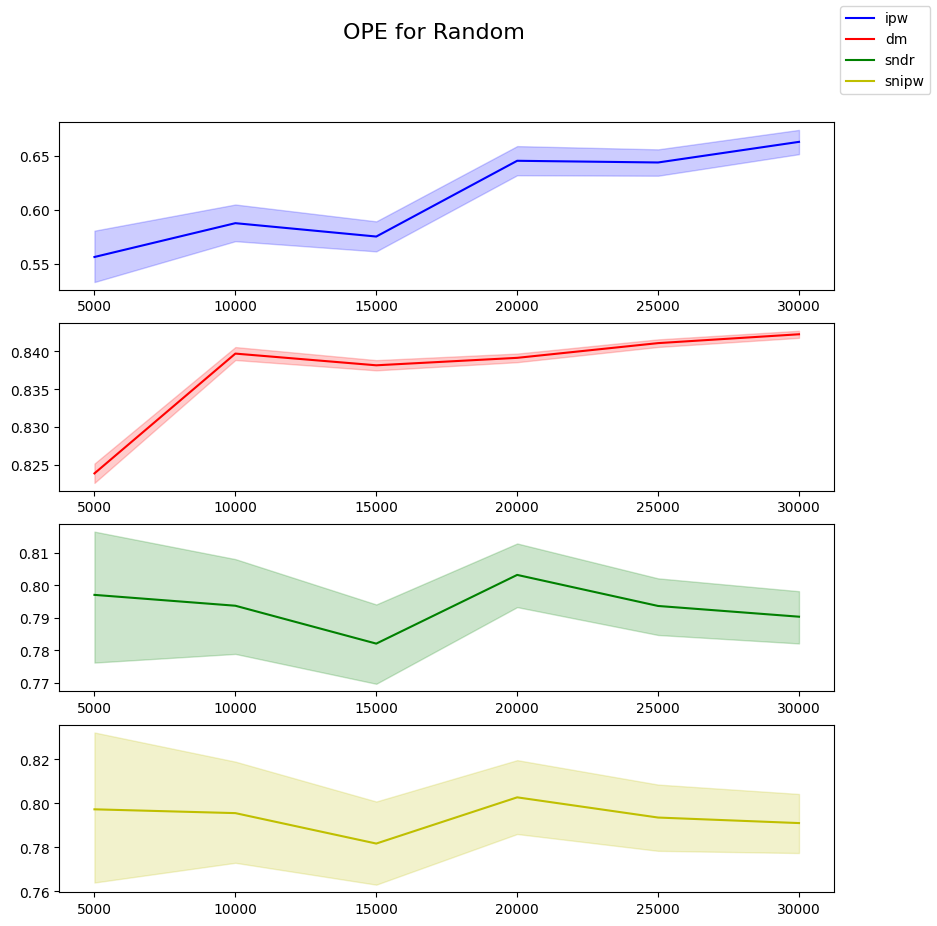

In [23]:
plot_disjoint_res(Vs_3, CIs_3, 'Random')

In [24]:
out_str = f"Scores for UCB true"
for key, val in Vs_1[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for UCB true ipw : 506.013, dm : 840.906, sndr : 781.905, snipw : 783.101


In [25]:
out_str = f"Scores for Lin_UCB true"
for key, val in Vs_2[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for Lin_UCB true ipw : 952.283, dm : 849.667, sndr : 912.929, snipw : 911.867


In [26]:
out_str = f"Scores for random true"
for key, val in Vs_3[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for random true ipw : 662.650, dm : 842.262, sndr : 790.430, snipw : 791.062


In [27]:
print("USB all")
print(Vs_1)

USB all
[{'ipw': 0.3802741755718977, 'dm': 0.8224162327715694, 'sndr': 0.7758526962277758, 'snipw': 0.779034373921589}, {'ipw': 0.4111516265638647, 'dm': 0.8383390138101138, 'sndr': 0.7647832551020918, 'snipw': 0.7694462266747212}, {'ipw': 0.4021092869989806, 'dm': 0.836783461375512, 'sndr': 0.7549867616610161, 'snipw': 0.7566834894824658}, {'ipw': 0.49061053945516325, 'dm': 0.8377726836396325, 'sndr': 0.7947393613933905, 'snipw': 0.7947453142248766}, {'ipw': 0.4904355929462641, 'dm': 0.8397279250006571, 'sndr': 0.7865483333727286, 'snipw': 0.7872054375611185}, {'ipw': 0.5060128768256055, 'dm': 0.8409062082499725, 'sndr': 0.7819049102234696, 'snipw': 0.7831006800006055}]


In [28]:
print("Lin USB all")
print(Vs_2)

Lin USB all
[{'ipw': 1.129434914742264, 'dm': 0.8322031598662423, 'sndr': 0.9025517731079584, 'snipw': 0.9061903448319585}, {'ipw': 1.0941283561171837, 'dm': 0.847222683275921, 'sndr': 0.9176501054039934, 'snipw': 0.9182545830488466}, {'ipw': 1.1549788936282974, 'dm': 0.8456051522120988, 'sndr': 0.9082625651458057, 'snipw': 0.9086121666911774}, {'ipw': 1.0550978832202056, 'dm': 0.8465293027291187, 'sndr': 0.9106790755951175, 'snipw': 0.9102836050075508}, {'ipw': 1.0043163863551572, 'dm': 0.8484349316870189, 'sndr': 0.9104765976820339, 'snipw': 0.91016236462951}, {'ipw': 0.9522829353859856, 'dm': 0.84966686091999, 'sndr': 0.9129291077500248, 'snipw': 0.9118666030631887}]


In [29]:
print("Random all")
print(Vs_3)

Random all
[{'ipw': 0.5559096823737336, 'dm': 0.8238929457911257, 'sndr': 0.796934959651036, 'snipw': 0.796990334667203}, {'ipw': 0.5873146682093487, 'dm': 0.8397112357916603, 'sndr': 0.7936788510045825, 'snipw': 0.7954354239362388}, {'ipw': 0.5750059424614501, 'dm': 0.8381674672683826, 'sndr': 0.7820565361426555, 'snipw': 0.7816913609750227}, {'ipw': 0.6451246105036964, 'dm': 0.8391506938854753, 'sndr': 0.803318389152192, 'snipw': 0.8027271102514236}, {'ipw': 0.6435865058765762, 'dm': 0.8410927405294663, 'sndr': 0.7937279096997005, 'snipw': 0.7935888338914261}, {'ipw': 0.6626504217307786, 'dm': 0.8422622483621113, 'sndr': 0.790429832468739, 'snipw': 0.7910622747731548}]


In [30]:
print("Estimated confidence intervals UCB:")
print(pd.DataFrame(CIs_1[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(CIs_2[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(CIs_3[-1]).to_string())

Estimated confidence intervals UCB:
                       ipw        dm      sndr     snipw
mean              0.506009  0.840904  0.781829  0.783095
95.0% CI (lower)  0.489517  0.840428  0.767888  0.757572
95.0% CI (upper)  0.522446  0.841371  0.795528  0.808532
Estimated confidence intervals Lin UCB:
                       ipw        dm      sndr     snipw
mean              0.952232  0.849665  0.912891  0.911818
95.0% CI (lower)  0.935609  0.849208  0.907619  0.895900
95.0% CI (upper)  0.969004  0.850114  0.917951  0.927878
Estimated confidence intervals Random:
                       ipw        dm      sndr     snipw
mean              0.662647  0.842261  0.790356  0.791058
95.0% CI (lower)  0.651247  0.841787  0.782095  0.777449
95.0% CI (upper)  0.673724  0.842725  0.798226  0.804282


In [31]:
print(Vs_1[-1])
print(Vs_2[-1])
print(Vs_3[-1])

{'ipw': 0.5060128768256055, 'dm': 0.8409062082499725, 'sndr': 0.7819049102234696, 'snipw': 0.7831006800006055}
{'ipw': 0.9522829353859856, 'dm': 0.84966686091999, 'sndr': 0.9129291077500248, 'snipw': 0.9118666030631887}
{'ipw': 0.6626504217307786, 'dm': 0.8422622483621113, 'sndr': 0.790429832468739, 'snipw': 0.7910622747731548}


In [32]:
def plot_res_two_politics(CIs_p1, CIs_p2, model_p1, model_p2):
    fig, ax = plt.subplots(4, figsize=(15, 10))
    x = [5000, 10000, 15000, 20000, 25000, 30000]
    # x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i=0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p1]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p1]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p1]

        ax[i].plot(x, y_est, '-', label=model_p1+"_"+name, color = colors[0])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p2]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p2]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p2]

        ax[i].plot(x, y_est, '-', label=model_p2+"_"+name, color = colors[1])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
        ax[i].set_title(name)
        
        i = i+1
    fig.suptitle("OPE for " + model_p1 + " and " + model_p2, fontsize=16)
    fig.legend()

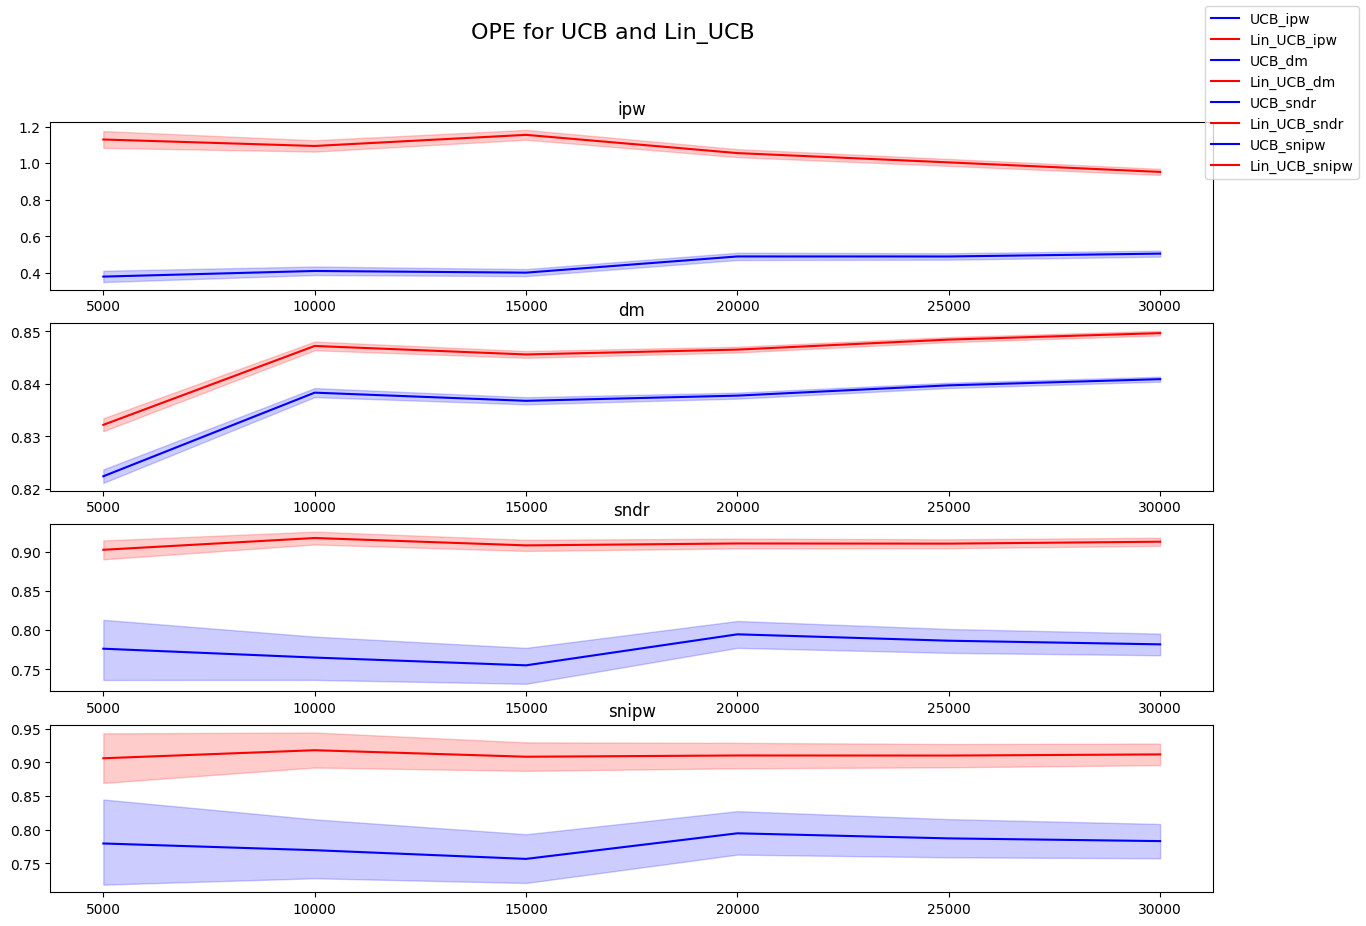

In [33]:
plot_res_two_politics(CIs_1, CIs_2, "UCB", "Lin_UCB")

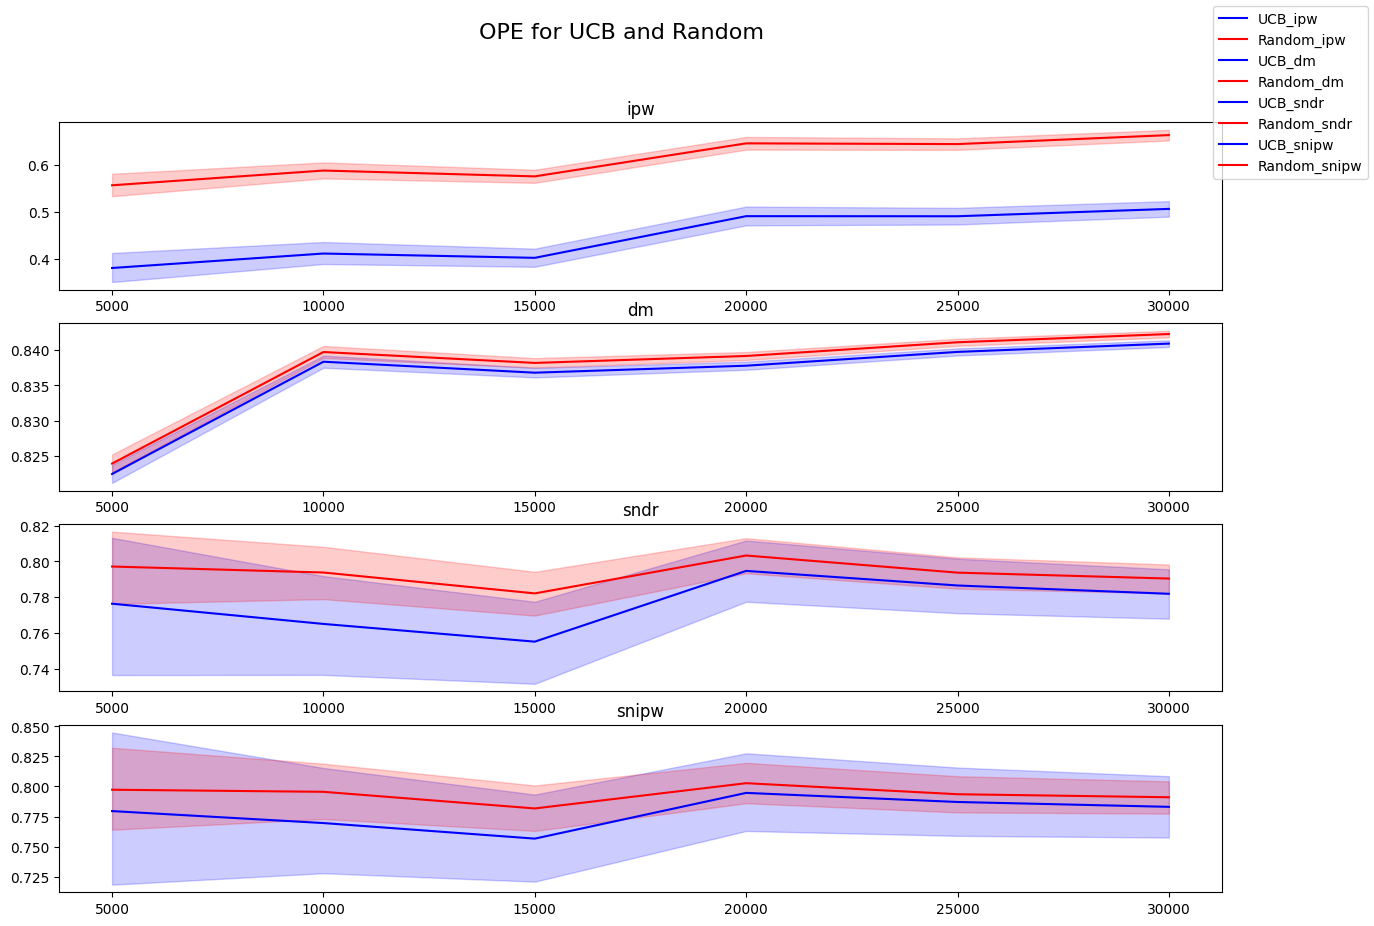

In [34]:
plot_res_two_politics(CIs_1, CIs_3, "UCB", "Random")

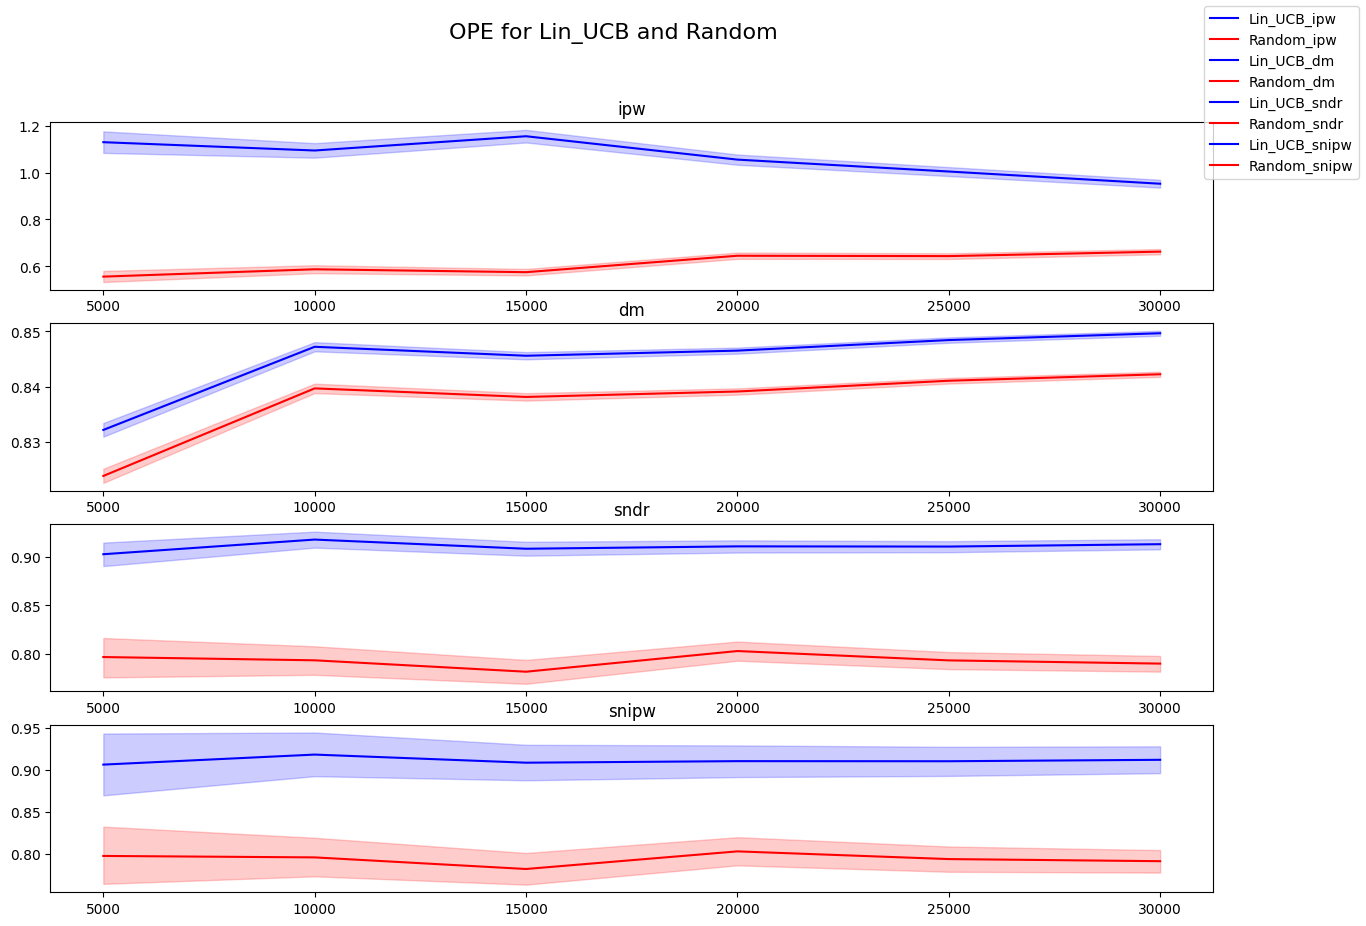

In [35]:
plot_res_two_politics(CIs_2, CIs_3, "Lin_UCB", "Random")

In [36]:
def plot_join_res(Vs, CIs, model):
    fig, ax = plt.subplots(figsize=(10, 10))
    x = [5000, 10000, 15000, 20000, 25000, 30000]
    # x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw','dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

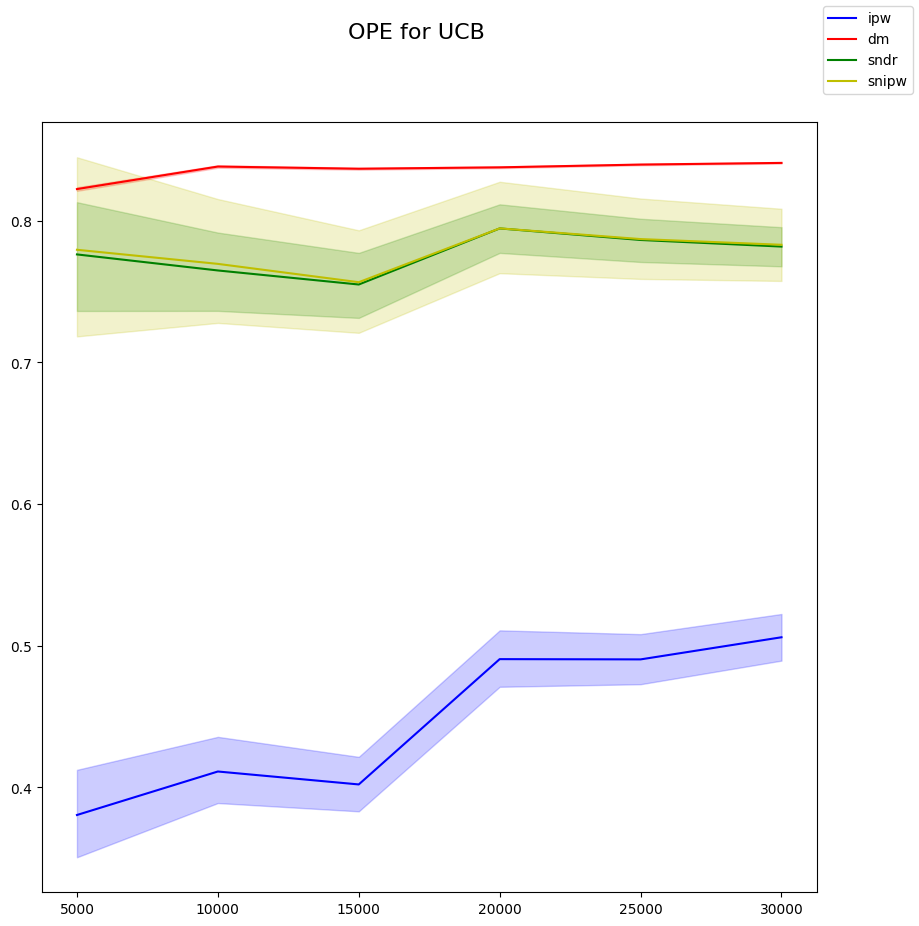

In [37]:
plot_join_res(Vs_1, CIs_1, 'UCB')

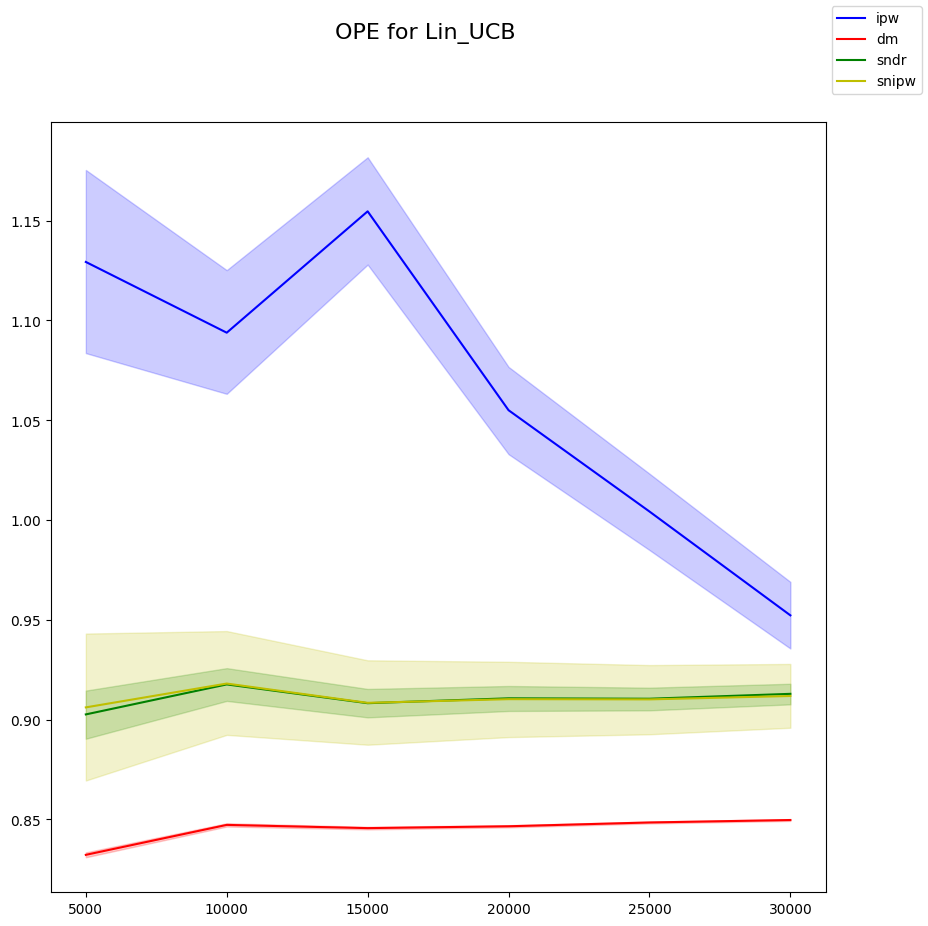

In [38]:
plot_join_res(Vs_2, CIs_2, 'Lin_UCB')

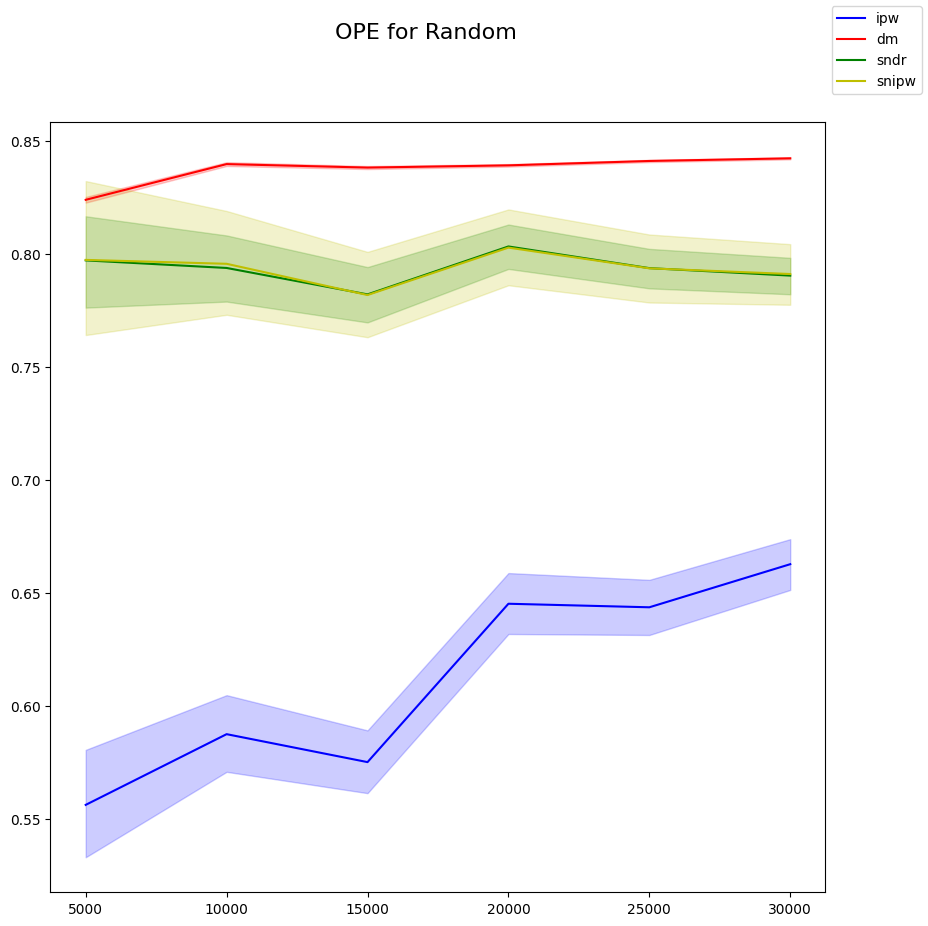

In [39]:
plot_join_res(Vs_3, CIs_3, 'Random')

In [40]:
test_pos_idx = np.where(bandit_feedback_test['reward'] == 1)[0]
test_actions_pos = bandit_feedback_test['action'][test_pos_idx]
test_context_pos = bandit_feedback_test['context'][test_pos_idx]

In [57]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 1))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 1))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 1))

Ucb


 96%|█████████▋| 27/28 [00:07<00:00,  3.72it/s]


{'hr@1': 0.018518518518518517, 'mrr@1': 0.018518518518518517, 'ndcg@1': 0.018518518518518517, 'cov@1': 0.015194437290754571}
Lin_ucb


 96%|█████████▋| 27/28 [00:03<00:00,  8.77it/s]


{'hr@1': 0.0, 'mrr@1': 0.0, 'ndcg@1': 0.0, 'cov@1': 0.015709502961627608}
Random


 96%|█████████▋| 27/28 [00:07<00:00,  3.78it/s]

{'hr@1': 0.007407407407407408, 'mrr@1': 0.007407407407407408, 'ndcg@1': 0.007407407407407408, 'cov@1': 0.04326551635333505}


In [58]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 3))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 3))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 3))

Ucb


 96%|█████████▋| 27/28 [00:07<00:00,  3.75it/s]


{'hr@3': 0.044444444444444446, 'mrr@3': 0.02839506172839506, 'ndcg@3': 0.03663996022486805, 'cov@3': 0.07957764614988411}
Lin_ucb


 96%|█████████▋| 27/28 [00:03<00:00,  8.79it/s]


{'hr@3': 0.0, 'mrr@3': 0.0, 'ndcg@3': 0.0, 'cov@3': 0.09812001030131341}
Random


 96%|█████████▋| 27/28 [00:07<00:00,  3.75it/s]

{'hr@3': 0.018518518518518517, 'mrr@3': 0.012345679012345678, 'ndcg@3': 0.013932812989418205, 'cov@3': 0.15786762812258562}


In [59]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 10))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 10))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 10))

Ucb


 96%|█████████▋| 27/28 [00:07<00:00,  3.75it/s]


{'hr@10': 0.14444444444444443, 'mrr@10': 0.04334215167548501, 'ndcg@10': 0.09844251615673633, 'cov@10': 0.22147823847540563}
Lin_ucb


 96%|█████████▋| 27/28 [00:03<00:00,  8.85it/s]


{'hr@10': 0.0, 'mrr@10': 0.0, 'ndcg@10': 0.0, 'cov@10': 0.25882049961370074}
Random


 96%|█████████▋| 27/28 [00:07<00:00,  3.79it/s]

{'hr@10': 0.09259259259259259, 'mrr@10': 0.023318636096413874, 'ndcg@10': 0.04607776652597037, 'cov@10': 0.4321400978624775}


In [116]:
# ssh hdilab@172.21.136.110 -p 22